# Imports

In [2]:
#navigation
import os

#data wrangling
import pandas as pd
import numpy as np
import operator
from operator import itemgetter

#model building
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import feature_importance_permutation


#model scoring
from sklearn.metrics import r2_score, mean_squared_error,explained_variance_score, mean_absolute_error
import eli5

#data visualization
import matplotlib.pyplot as plt
import pylab 

#others
import warnings
warnings.filterwarnings(action='once')


In [3]:
import matplotlib
plt.rc('font', family='serif') # change font types for plots
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

# Data

In [4]:
file_path = './data/df_aggregated_spc.csv'
combined_data = pd.read_csv(file_path)
combined_data['dataset_original'] = combined_data['dataset']

#NTF2 topology should not be used so remove those rows
ntf2_inx = combined_data[combined_data['topology']=='NTF2'].index
combined_data = combined_data.drop(ntf2_inx)


print("Before: ",len(combined_data))

#make sure you only use Rocklin library
combined_data = combined_data[combined_data["dataset"]=="Rocklin"].reset_index(drop="True")



print("After: ",len(combined_data))

col_order = list(combined_data.columns.values)
col_order.insert(2, col_order.pop(col_order.index('dataset_original')))
combined_data = combined_data[col_order]
combined_data['stabilityscore_cnn_calibrated_2classes'] = combined_data['stabilityscore_cnn_calibrated'] > 1


train, test = train_test_split(combined_data, test_size=0.2, random_state=5, stratify=combined_data[['topology', 'dataset_original']])

# list of feature columns to use and/or normalize:
ros_fet_path =  './data/rosetta_features.csv'
spc_fet_path =  './data/entropy_features.csv'

ros_features = list(pd.read_csv(ros_fet_path).iloc[:,0])
spc_features = list(pd.read_csv(spc_fet_path).iloc[:,0])


feature_cols = ros_features+spc_features


Before:  80257
After:  16159


In [5]:
combined_data.describe()[spc_features]

,S_PC,Mean_H_entropy,Mean_L_entropy,Mean_E_entropy,Mean_res_entropy,SumH_entropies,SumL_entropies,SumE_entropies,H_max_entropy,H_min_entropy,H_range_entropy,L_max_entropy,L_min_entropy,L_range_entropy,E_max_entropy,E_min_entropy,E_range_entropy
count,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000,16159.000000
mean,8.454796,0.035459,0.519237,0.190204,0.202816,0.413363,5.409969,2.631476,1.445003,-1.238004,2.683008,1.595573,-0.368628,1.964201,1.031362,-0.614157,1.645519
std,4.184565,0.144341,0.158734,0.140972,0.102468,2.807020,1.644253,2.121031,0.365907,0.395758,0.600815,0.399101,0.296785,0.489464,0.516884,0.373509,0.817239
min,-11.389000,-0.597000,-0.069800,-0.356500,-0.264907,-13.902000,-0.698000,-3.894000,0.073000,-3.667000,0.750000,0.537000,-1.945000,0.351000,0.000000,-2.514000,0.000000
25%,6.051000,-0.060021,0.410374,0.081792,0.141826,-1.140000,4.292000,0.799500,1.196000,-1.420000,2.243000,1.297000,-0.610000,1.620500,0.845000,-0.867000,1.385000
50%,8.965000,0.035833,0.521000,0.197167,0.213047,0.626000,5.415000,2.486000,1.391000,-1.185000,2.612000,1.601000,-0.318000,1.971000,1.221000,-0.655000,1.893000
75%,11.326500,0.133038,0.629519,0.289000,0.273554,2.262000,6.522000,4.116000,1.727000,-0.985000,3.121000,1.914500,-0.172000,2.288500,1.380000,-0.378000,2.189000
max,21.783000,0.555154,1.064000,0.805875,0.534975,10.512000,11.531000,10.394000,2.365000,-0.162000,5.609000,2.640000,0.624000,3.861000,1.983000,0.172000,4.123000


In [6]:
def train_linear_regression(features):
    #set up splits
    X_train = train[features]
    y_train = train["S_PC"]

    X_test = test[features]
    y_test = test["S_PC"]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    y = pd.concat([y_train,y_test])
    
    
    #set up a linear regression trained to predict S_PC
    model_lnr = LinearRegression(normalize=False)

    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)
    
    
    r2_val = r2_score(y_test.values,y_pred_lnr)
    
    return r2_val

# Model Building

### Data Split

In [7]:
#set up splits
X_train = train[ros_features]
y_train = train["S_PC"]

X_test = test[ros_features]
y_test = test["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
X = X.reset_index(drop=True)

y = pd.concat([y_train,y_test])
y = y.reset_index(drop=True)

## Linear Regression

In [8]:
#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#predict
y_pred_lnr = model_lnr.predict(X_test_std)

#get results
print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
range_spc = y_test.max() - y_test.min() #get range of predicted values
print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

R2 Score:  0.811218754033234
RMSE/Range:  0.05942799354999872
MAE/Range:  0.04685839725240378


In [9]:
#code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
predicted = cross_val_predict(model_lnr, X,y, cv=10)

In [10]:
print("Cross Validated R2:",round(r2_score(predicted, y),3))

Cross Validated R2: 0.766


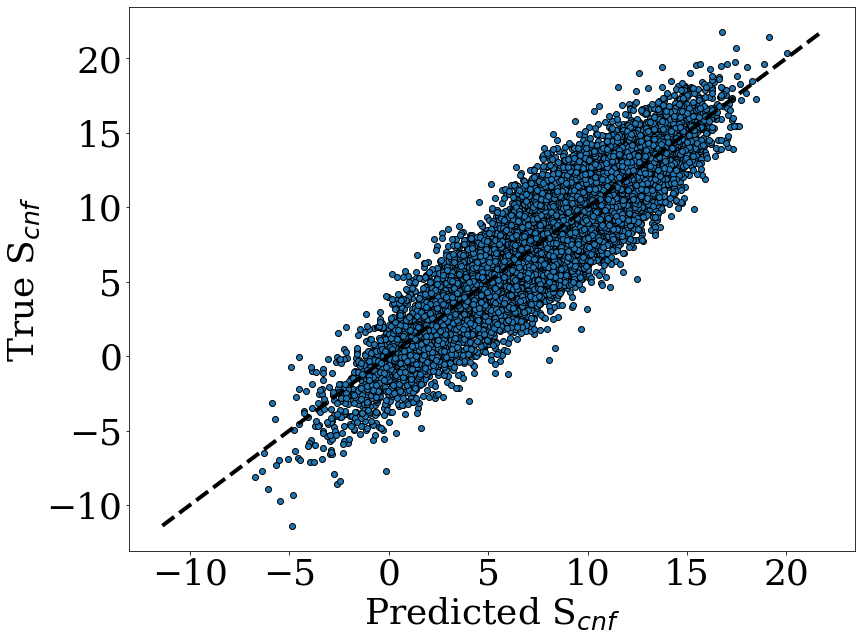

In [11]:
fig, ax = plt.subplots(0,0,figsize=(13,10),subplot_kw={"aspect":1})

plt.scatter(predicted,y, edgecolors=(0, 0, 0),label='predicted value')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.ylabel('True S$_{cnf}$',fontsize="36")
plt.xticks(fontsize='36')
plt.yticks(fontsize='36')
plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
#plt.legend(fontsize="30")

#plt.savefig("./SavedFigures/Figure5a",dpi=300,bbox_inches='tight')
plt.show()

In [12]:
#color coded plot by topologies
unique_topologies = combined_data.topology.unique()

In [13]:
unique_topologies

array(['EEHEE', 'EHEE', 'HEEH', 'HHH'], dtype=object)

In [14]:
inx_dict = {}

reindexed_df = combined_data.iloc[y.index,:]
for top in unique_topologies:
    #will generate a key entry with list of indices of proteins in given topology
    inx_dict[top] = reindexed_df[reindexed_df["topology"]==top].index


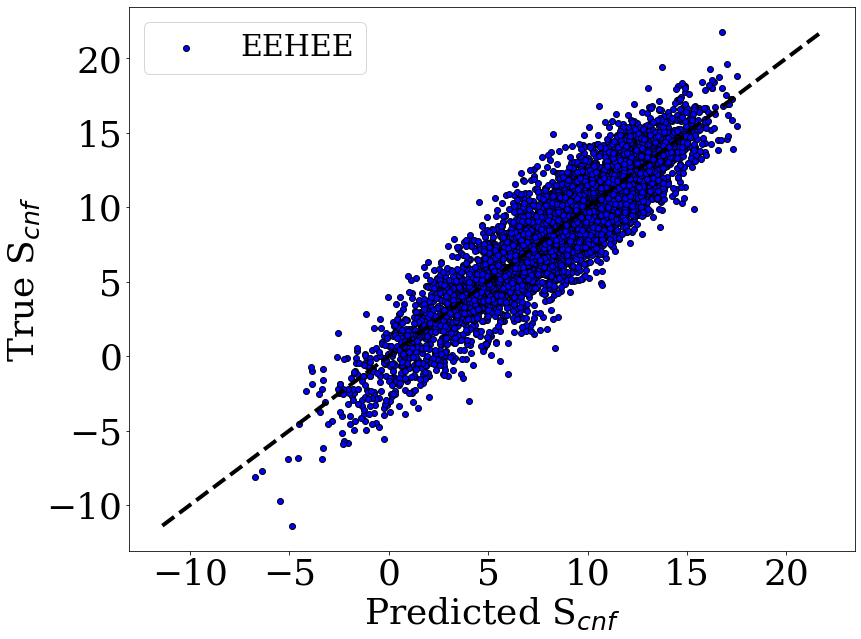

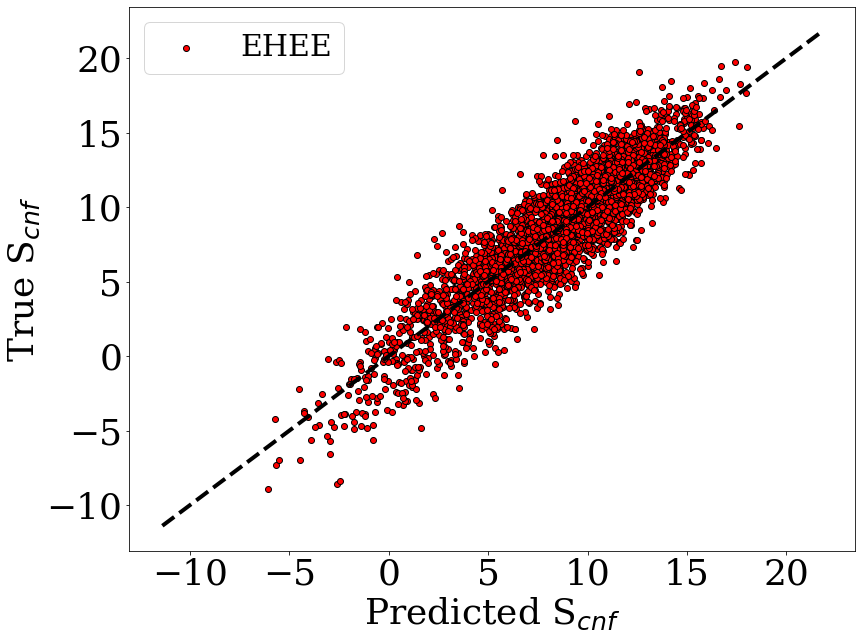

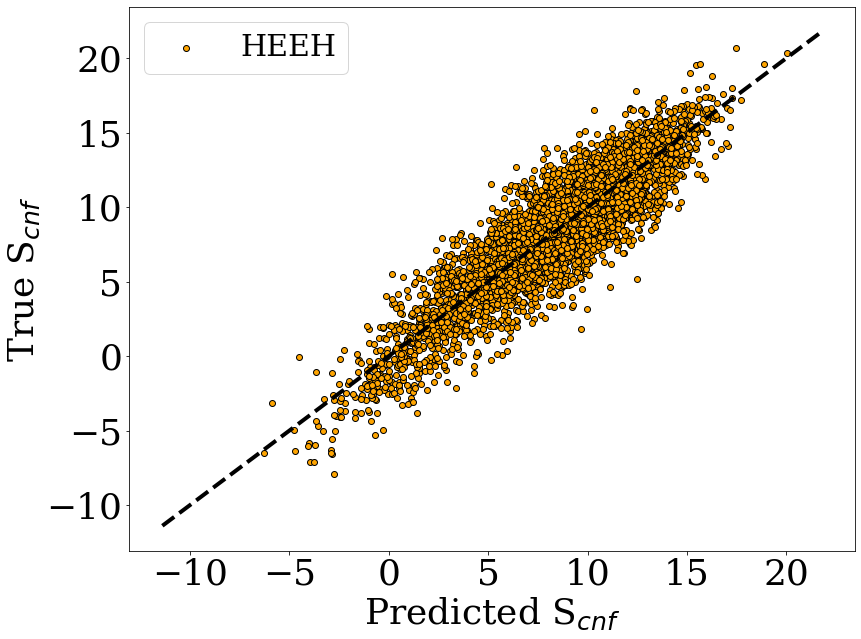

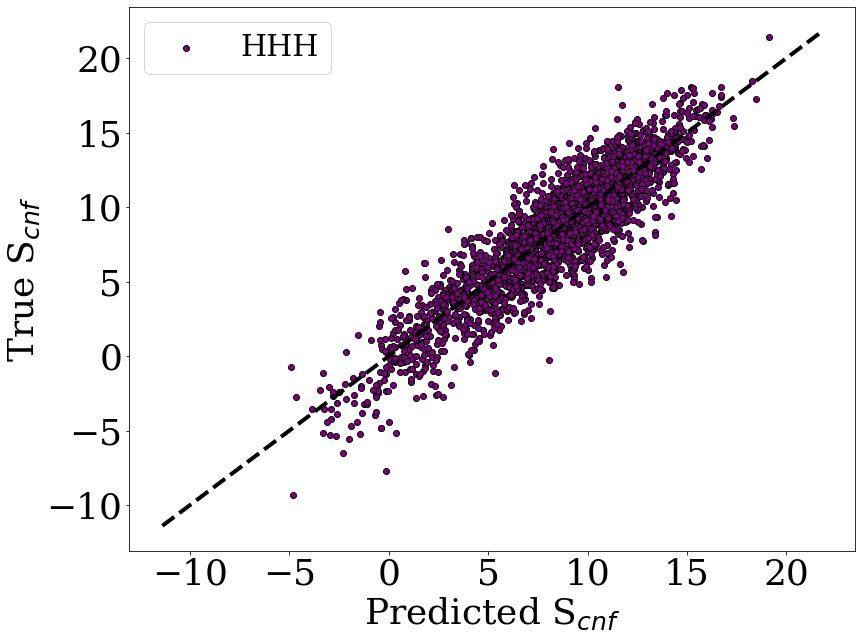

In [15]:
golden = (1 + 5**(1/2))/2
colors = ["blue","red",'orange','purple','green','grey',
          'darkorange','darkblue','yellow','black','skyblue']

for i in range(len(inx_dict.keys())):
    fig, ax = plt.subplots(0,0,figsize=(13,10),subplot_kw={"aspect":1})
    key = unique_topologies[i]
    inxs = combined_data.iloc[inx_dict[key],:]['topology'].index
    plt.scatter(predicted[inxs],y[inxs], edgecolors=(0, 0, 0),label=unique_topologies[i],color=colors[i])
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.ylabel('True S$_{cnf}$',fontsize="36")
    plt.xticks(fontsize='36')
    plt.yticks(fontsize='36')
    plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
    plt.legend(fontsize="30")
    #plt.title("Linear Regression of Rosetta Features predicting S$_{cnf}$",fontsize="28")
    #plt.savefig("./SavedFigures/Figure5a_%s"%unique_topologies[i],dpi=300,bbox_inches='tight')
    plt.show()

## Regression Coefficients

In [24]:
train_linear_regression(["buried_np","exposed_hydrophobics","buried_minus_exposed"])

0.12462822171269627

In [25]:
zipped_coeff = zip(ros_features,list(model_lnr.coef_))
coeff_dict = {}
for pair in zipped_coeff:
    #print(pair)
    if abs(pair[1]) > 10**3:
        coeff_dict[pair[0]] = pair[1]

In [26]:
sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
sorted_coeff_dict = dict(sorted_dict_tuple)

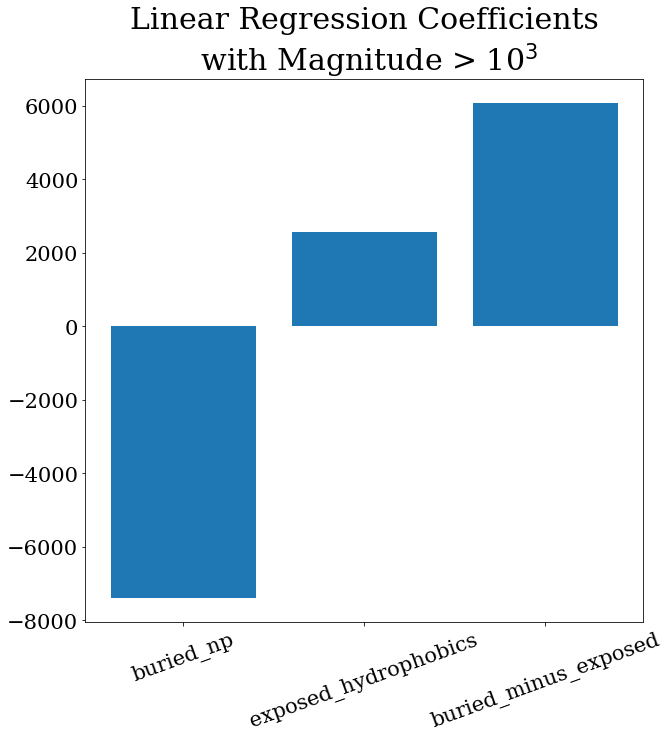

In [27]:
sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
f, ax = plt.subplots(figsize=(10,10))
ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
plt.xticks(rotation="20",fontsize="21")
plt.yticks(fontsize='21')
plt.title("Linear Regression Coefficients\n with Magnitude > 10$^{3}$",fontsize=30)
plt.show()

In [28]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_lnr.predict, 
    X=X_test_std.values,
    y=y_test,
    metric='r2',
    num_rounds=10)


std = np.std(imp_all, axis=1)

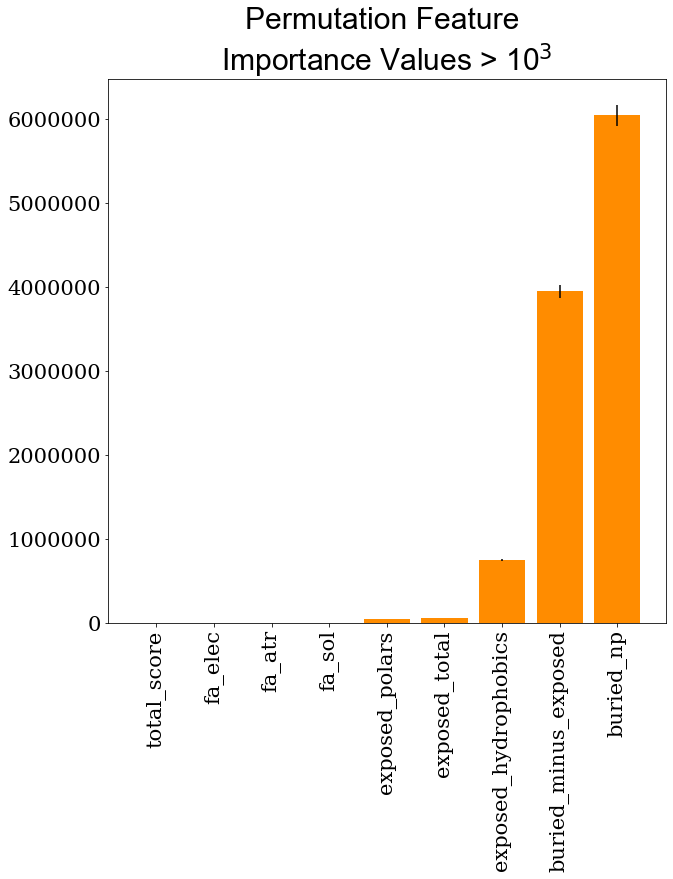

In [29]:
zipped_perm = zip(X_test_std.columns,list(imp_vals),std)
perm_dict = {}
for pair in zipped_perm:
    if abs(pair[1]) > 10**3:
        perm_dict[pair[0]] = [pair[1],pair[2]]

sorted_dict_tuple = sorted(perm_dict.items(), key=operator.itemgetter(1))
sorted_perm_dict = dict(sorted_dict_tuple)

sorted_coeffs = [sorted_perm_dict[key][0] for key in sorted_perm_dict]
sorted_coeffs_std = [sorted_perm_dict[key][1] for key in sorted_perm_dict]
f, ax = plt.subplots(figsize=(10,10))
ax.bar(sorted_perm_dict.keys(), sorted_coeffs,yerr=sorted_coeffs_std,color='darkorange')
plt.xticks(rotation="90",fontsize="21")
plt.yticks(fontsize='21')
model_score = round(model_lnr.score(X_test_std,y_test),3)
plt.title("Permutation Feature \nImportance Values > 10$^{3}$",fontsize=30,fontname='Arial')
plt.show()

In [30]:
#make a dictionary of absolute values
abs_val_dict = {}
for key,val in sorted_coeff_dict.items():
    abs_val_dict[key] = abs(val)
#sort the dictionary by decreasing order of absolute value
sorted_abs_val_dict = dict(sorted(abs_val_dict.items(), key=operator.itemgetter(1),reverse=True))

#get the names of the ordered dictionary features
ordered_list_names = list(sorted_abs_val_dict.keys())

#make an index map of those names
index_map = {v: i for i, v in enumerate(ordered_list_names)}


#sort the true values by this new index map
abs_sorted_coeff_dict = dict(sorted(sorted_coeff_dict.items(), key=lambda pair: index_map[pair[0]]))

In [31]:
original = .8112
new = []
fets_to_drop = list(abs_sorted_coeff_dict.keys())
fets_dropped = []

list_of_fets_dropped = []

for feature in fets_to_drop:
    
    new_ros_features = ros_features.copy() #make a copy of rosetta features
    for i in [feature]+fets_dropped:
        new_ros_features.remove(i) #drop the feature you are currently iterating on plus prev fets
    

    
    r2_val = train_linear_regression(new_ros_features)
    
    new.append(r2_val)
    
    copy_fets_dropped = fets_dropped.copy()
    copy_fets_dropped+=[feature]
    fets_dropped+=[feature]

    
    
    list_of_fets_dropped.append(copy_fets_dropped)

In [32]:
delta = [val - original for val in new]

results = pd.DataFrame(list(zip(list_of_fets_dropped,new,delta)))

In [33]:
results

,0,1,2
0,[buried_np],0.811254,0.000054
1,"[buried_np, buried_minus_exposed]",0.811169,-0.000031
2,"[buried_np, buried_minus_exposed, exposed_hydr...",0.811139,-0.000061


# Overabundance of alpha helices? 

In [73]:
# don't stratify data
train1, test1 = train_test_split(combined_data, test_size=0.2, random_state=4)

In [74]:
#set up splits
features=ros_features

X_train = train1[features]
y_train = train1["S_PC"]

X_test = test1[features]
y_test = test1["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
y = pd.concat([y_train,y_test])


#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
predicted = cross_val_predict(model_lnr, X,y, cv=10)

In [75]:
print("non Cross Validated R2:",round(r2_score(y_test.values,model_lnr.predict(X_test_std)),3))
print("Cross Validated R2:",round(r2_score(y,predicted),3))

non Cross Validated R2: 0.811
Cross Validated R2: 0.81


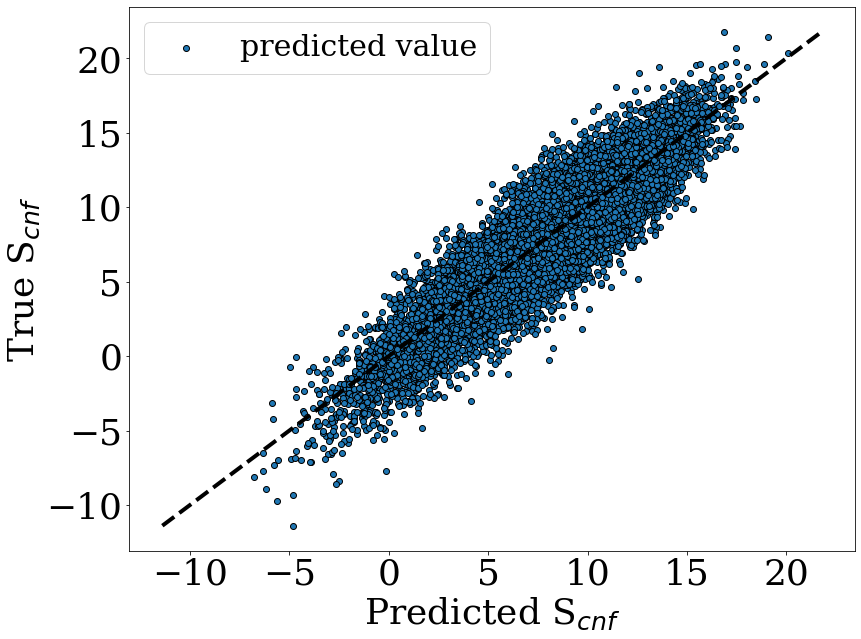

In [76]:
fig, ax = plt.subplots(0,0,figsize=(13,10),subplot_kw={"aspect":1})

plt.scatter(predicted,y, edgecolors=(0, 0, 0),label='predicted value')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.ylabel('True S$_{cnf}$',fontsize="36")
plt.xticks(fontsize='36')
plt.yticks(fontsize='36')
plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
plt.legend(fontsize="30")

plt.show()

Notice that whether or not you stratify the dataset on topology, the R-Squared value does not dramatically change. The Cross Validated R-Squared only increases a little in the unstratified from 0.863 to 0.879.

## Mutual information

In [77]:
from sklearn.feature_selection import mutual_info_regression

In [78]:
#set up splits
X_train = train[ros_features]
y_train = train["S_PC"]

X_test = test[ros_features]
y_test = test["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
y = pd.concat([y_train,y_test])

In [79]:
limits = range(100,1005,20)
y_axis_cv = []
cv = 30

for i in range(cv):
    y_axis_all = []
    for n in limits:
        X_sample = X.sample(n)
        mi_results = mutual_info_regression(X_sample,y[X_sample.index])
        y_axis_all.append(mi_results)
    y_axis_cv.append(y_axis_all)




KeyboardInterrupt: 

In [ ]:
objs = []
for i in y_axis_cv:
    objs.append(pd.DataFrame(i))


In [ ]:
df_cv = pd.concat(objs,axis=0)
df_cv.columns = X_train.columns

In [ ]:
counter = 0
for i in range(46*5):
    if counter == 45:
        counter=0
    
    df_cv.index[i]
    

In [ ]:
# get mean values of cross validated results
mean_cv = df_cv.groupby(df_cv.index).mean()
mean_cv.index = list(limits)
# get std values of cross validated results
std_cv = df_cv.groupby(df_cv.index).std()
std_cv.index = list(limits)

In [ ]:
print(mean_cv.iloc[-1,:].sort_values(ascending=False))

In [ ]:
mean_cv.iloc[-1,:].sort_values(ascending=False).index[:20].values

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,15))
for fet in mean_cv.iloc[-1,:].sort_values(ascending=False).index[:20]:
    plt.errorbar(mean_cv.index,mean_cv[fet].values,yerr=std_cv[fet],fmt='o',label=fet)
plt.legend()
plt.xlabel("Number of Randomly Selected samples",fontsize="28")
plt.ylabel("Mutual Information shared with S$_{PC}}$",fontsize="28")
plt.title("Mutual Information between features and S$_{PC}$",fontsize="30")
#plt.savefig("Figure7",bbox_inches="tight",dpi=300)
plt.show()

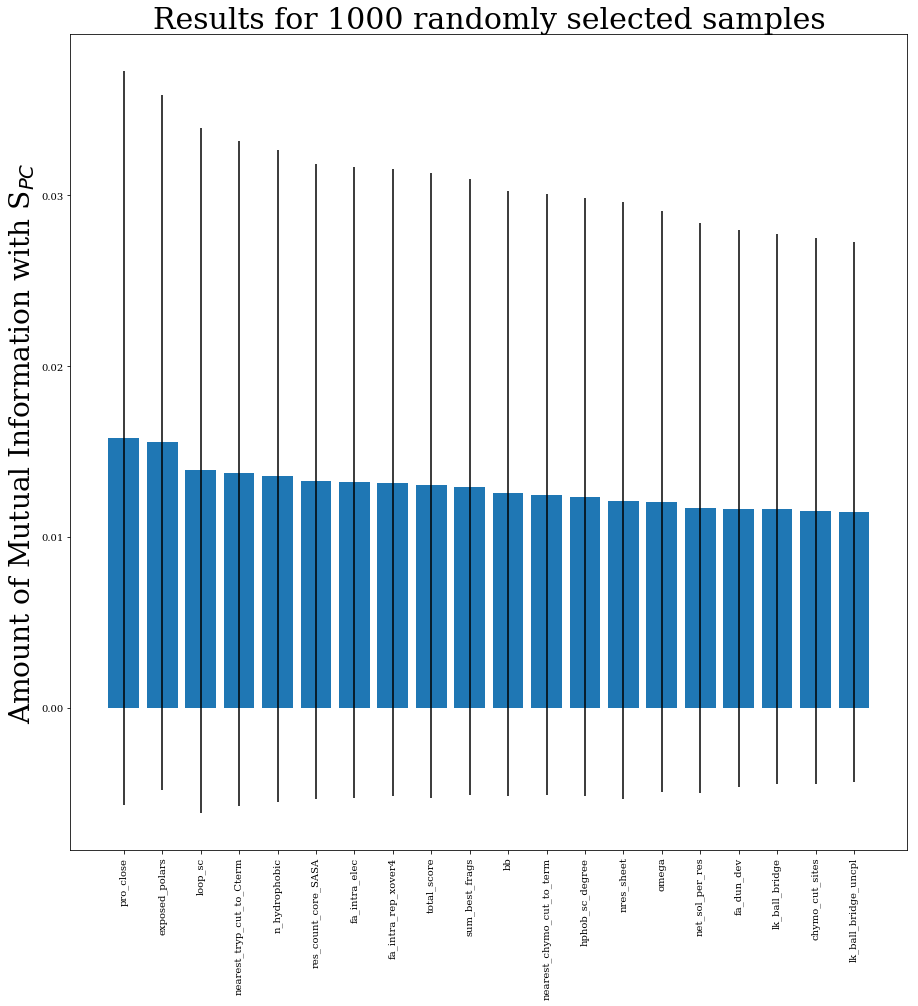

In [101]:
boop = mean_cv.iloc[-1,:].sort_values(ascending=False)
# boop =  boop[boop > .01]

boop_err = std_cv.iloc[-1,:].sort_values(ascending=False)
# boop_err = boop_err[boop > .01]

plt.figure(figsize=(15,15))
plt.bar(boop.index[:20],boop.values[:20],yerr=boop_err.values[:20])
plt.xticks(rotation="90")
plt.ylabel("Amount of Mutual Information with S$_{PC}$",fontsize="28")
plt.title("Results for 1000 randomly selected samples",fontsize="30")
plt.show()


In [102]:
mean_cv.iloc[-1,:][mean_cv.iloc[-1,:] > 0]

AlaCount          0.010379
T1_absq           0.008467
T1_netq           0.009550
Tend_absq         0.010476
Tend_netq         0.008235
                    ...   
total_score       0.013029
tryp_cut_sites    0.005211
two_core_each     0.011093
worst6frags       0.005253
worstfrag         0.009289
Name: 1000, Length: 111, dtype: float64

### Feature Downselection

In [34]:
from sklearn.feature_selection import SelectKBest
import sklearn

In [35]:
kbest = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=10)
kbest.fit(X,y)
downselected_features = sorted(list(zip(kbest.scores_,X.columns)),reverse=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [36]:
pd.DataFrame(downselected_features,columns=["F1-Score","Feature"]).to_csv("./data/DownselectedScores.csv",index=False)

In [37]:
print("")
for i in range(22):
    print(downselected_features[i])


(nan, 'dslf_fa13')
(nan, 'entropy')
(11385.847649606336, 'lk_ball_iso')
(10862.963761537902, 'hbond_sr_bb')
(10492.399017644126, 'fa_atr')
(10338.900731585067, 'frac_sheet')
(10229.036110788413, 'nres_sheet')
(10066.055430728584, 'nres_helix')
(9911.57671090477, 'frac_helix')
(9318.316595338849, 'net_sol_per_res')
(9042.142472437983, 'fa_atr_per_res')
(8919.599198316226, 'hbond_lr_bb_per_sheet')
(8531.758763471678, 'bb')
(8406.284666566977, 'hbond_lr_bb')
(8091.921831468602, 'lk_ball')
(6594.804346033034, 'net_atr_per_res')
(6214.772681225935, 'fa_sol')
(5172.735031932249, 'holes')
(4868.1695963992215, 'Tend_absq')
(4860.17885835469, 'degree')
(4605.187904861345, 'nres')
(4605.187904861345, 'n_res')


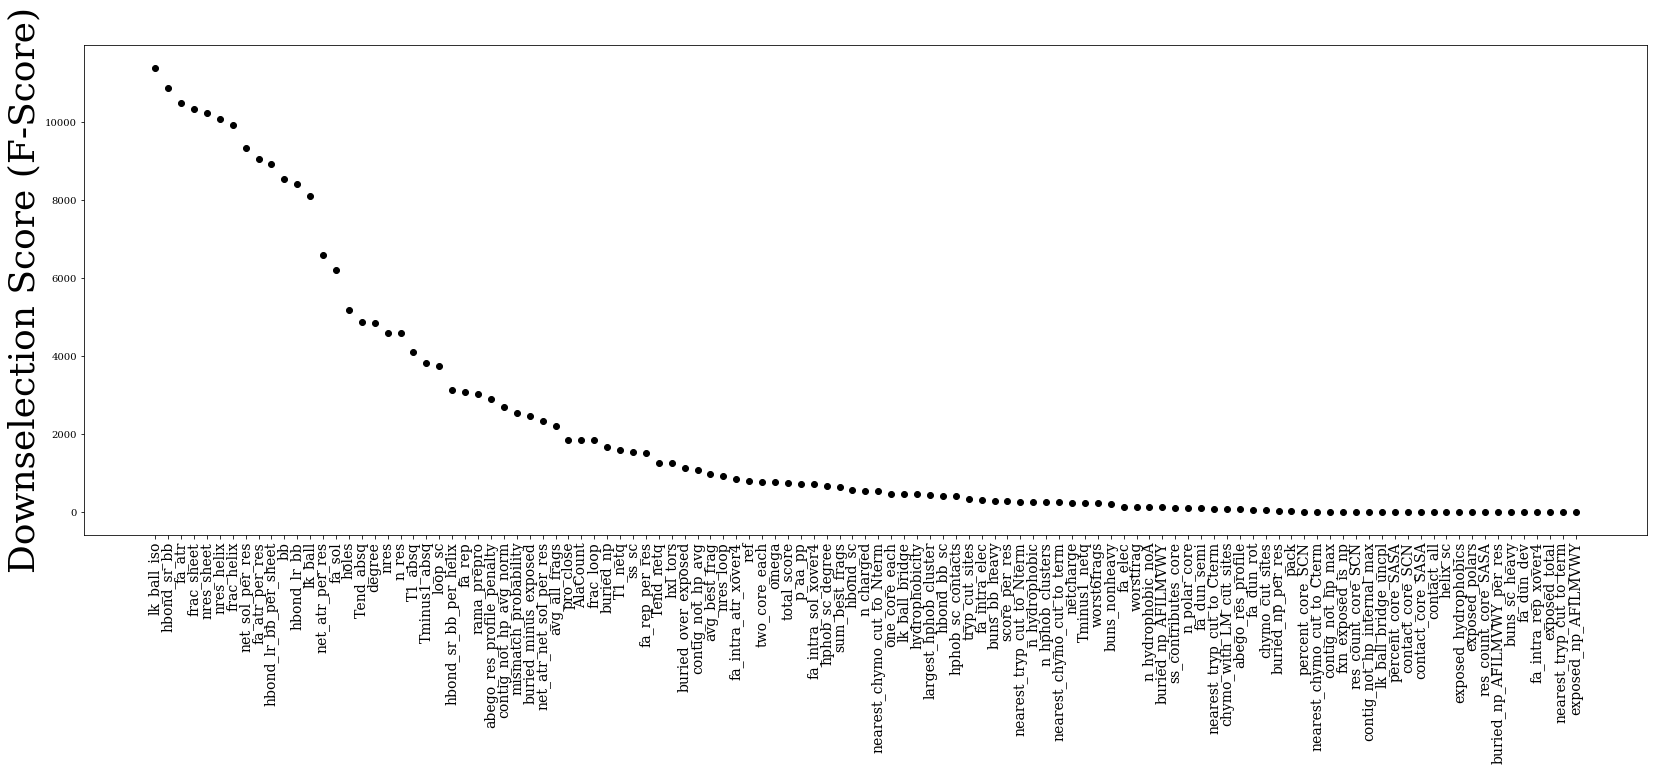

In [38]:
plt.figure(figsize=(28,9))
plt.scatter([i[1] for i in downselected_features[2:]],[i[0] for i in downselected_features[2:]],color='black')
plt.ylabel("Downselection Score (F-Score)",fontsize="36")
#plt.title("Downselected Feature Importances",fontsize="30")
plt.xticks(rotation="90",fontsize='14')
#plt.savefig("./SavedFigures/DownselectedFeatureImportances",dpi=1200, bbox_inches='tight')
plt.show()

It seems like after the first 20 or so features the downselection tool starts to value the features as much less important. Let's see for how much variance the first 20 features account for:

In [39]:
print("Features used: \n",[i[1] for i in downselected_features[2:3]])
print()
print("R2 score:")
print(train_linear_regression([i[1] for i in downselected_features[2:3]]))


Features used: 
 ['lk_ball_iso']

R2 score:
0.4136956675351151


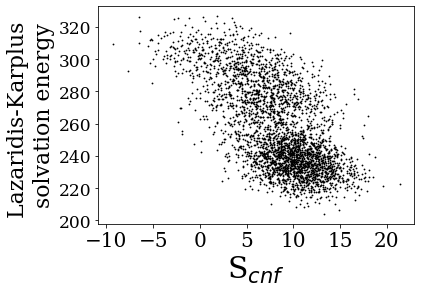

In [40]:
plt.plot(test['S_PC'],test["lk_ball_iso"],marker='o',markersize=.8,linestyle='',c='black')
plt.gca().set_aspect(1/5.8)
plt.xlabel("S$_{cnf}$",fontsize="30")
plt.ylabel("Lazaridis-Karplus \nsolvation energy",fontsize="22")

plt.yticks(fontsize="17")
plt.xticks(fontsize='20')

#plt.title("S$_{cnf}$ vs number of a-helices",fontsize='25')
#plt.savefig("./SavedFigures/Figure8",dpi=1200,bbox_inches='tight')
plt.show()

In [41]:
import warnings
warnings.filterwarnings(action='ignore')

In [42]:
kData = []

kvals = [20,10,1]
for kval in kvals:
    kbest = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=kval)
    kbest.fit(X,y)
    #print(len(kbest.scores_))
    downselected_features = sorted(list(zip(kbest.scores_,X.columns)),reverse=True)
    r2Val = train_linear_regression([i[1] for i in downselected_features[2:2+kval]])
    kData.append([kval, [i[1] for i in downselected_features[2:2+kval]], r2Val])

In [43]:
kFeatureSets = pd.DataFrame(kData)

In [44]:
kFeatureSets.to_csv("./data/kFeatureSets_ROCKLIN.csv")

## LASSO Regression

In [126]:
def plot_zipped_results(zipped_results,model):
    cutoff=0
    coeff_dict = {}
    for pair in zipped_results:
        #print(pair)
        if abs(pair[1]) > cutoff:
            coeff_dict[pair[0]] = pair[1]

    coeff_dict

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    f, ax = plt.subplots(figsize=(13,10))
    ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
    plt.xticks(rotation="90",fontsize="36")
    plt.yticks(fontsize='36')
    
    textstr = "α = %s, R² = %0.3f"%(model.alpha,model.score(X_test_std,y_test))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=30,
        verticalalignment='top',bbox=props)
    
#     plt.savefig(f"./SavedFigures/Lasso_R2_{str(round(model.score(X_test_std,y_test),3))}.png",
#                 dpi=300,bbox_inches='tight')
    plt.show()

In [127]:
from sklearn.linear_model import Lasso

alpha= 0.5


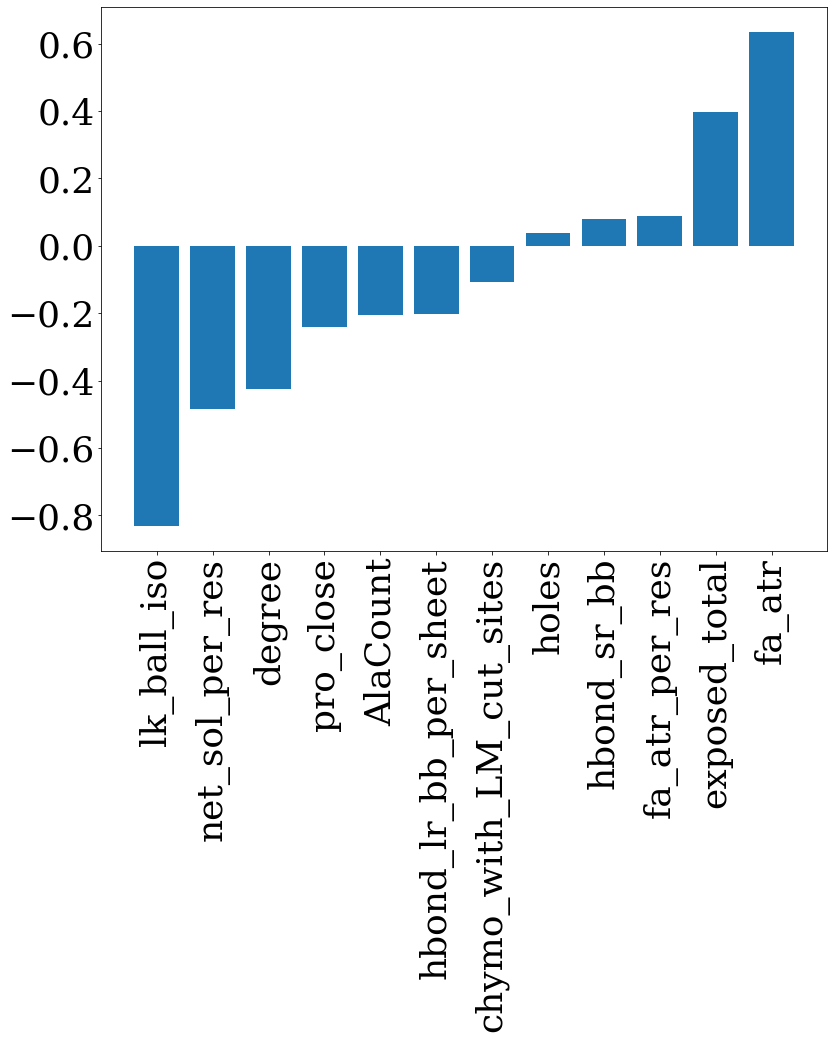

In [128]:
alpha_values = [.1]
lasso_models = []
for a in alpha_values:
    
    lasso_1 = Lasso(alpha=a)

    lasso_1.fit(X_train_std,y_train)

    lasso_1.score(X_test_std,y_test)

    lasso_coeffs = list(zip(X_train_std.columns,lasso_1.coef_))
    print(f"alpha= {a}")
    
    
    
    zipped_results=lasso_coeffs
    model=lasso_1
    cutoff=0
    coeff_dict = {}
    for pair in zipped_results:
        #print(pair)
        if abs(pair[1]) > cutoff:
            coeff_dict[pair[0]] = pair[1]

    coeff_dict

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    
    
    f, ax = plt.subplots(0,0,figsize=(13,10),subplot_kw={"aspect":1.618})
    plt.bar(sorted_coeff_dict.keys(), sorted_coeffs)
    plt.xticks(rotation="90",fontsize="36")
    plt.yticks(fontsize='36')
    
    
    textstr = "α = %s, R² = %0.3f"%(model.alpha,model.score(X_test_std,y_test))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=30,
        verticalalignment='top',bbox=props)
    
    plt.savefig(f"./SavedFigures/Lasso_R2_{str(round(model.score(X_test_std,y_test),3))}.png",
                dpi=300,bbox_inches='tight')
    plt.show()
    

    print()

In [129]:
pd.DataFrame.from_dict(sorted_coeff_dict,orient="index").to_csv("./data/LassoCoeffs.csv")


alpha= 2


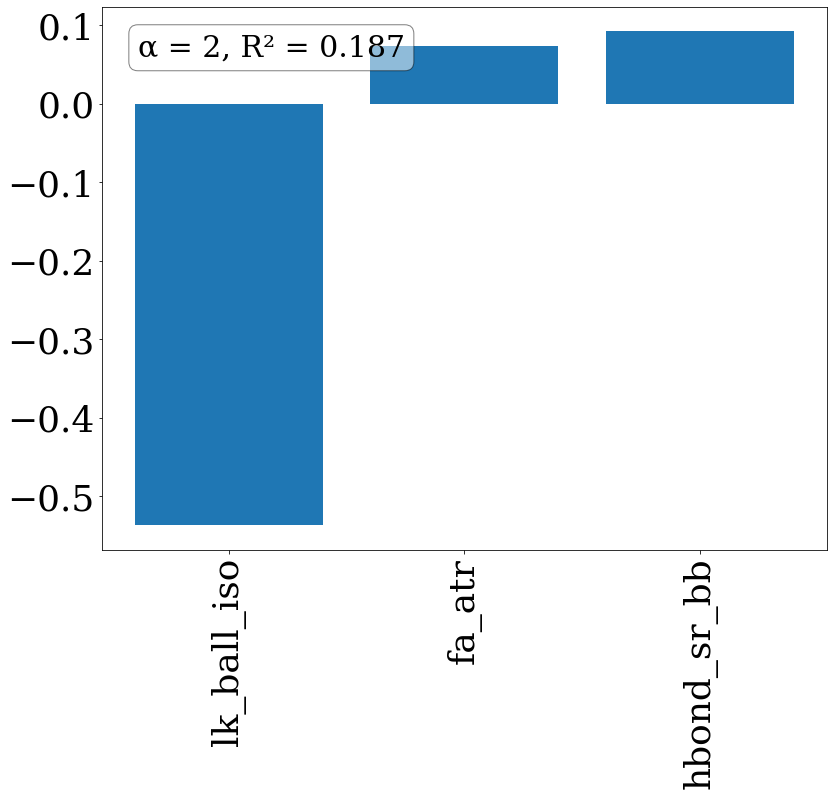


alpha= 1


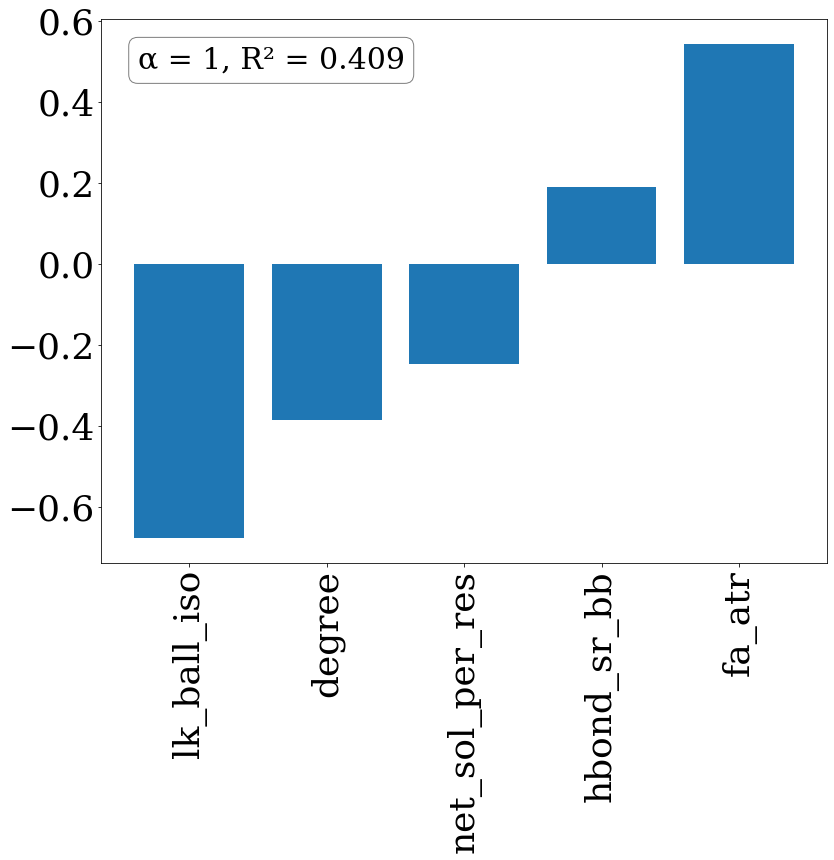


alpha= 0.5


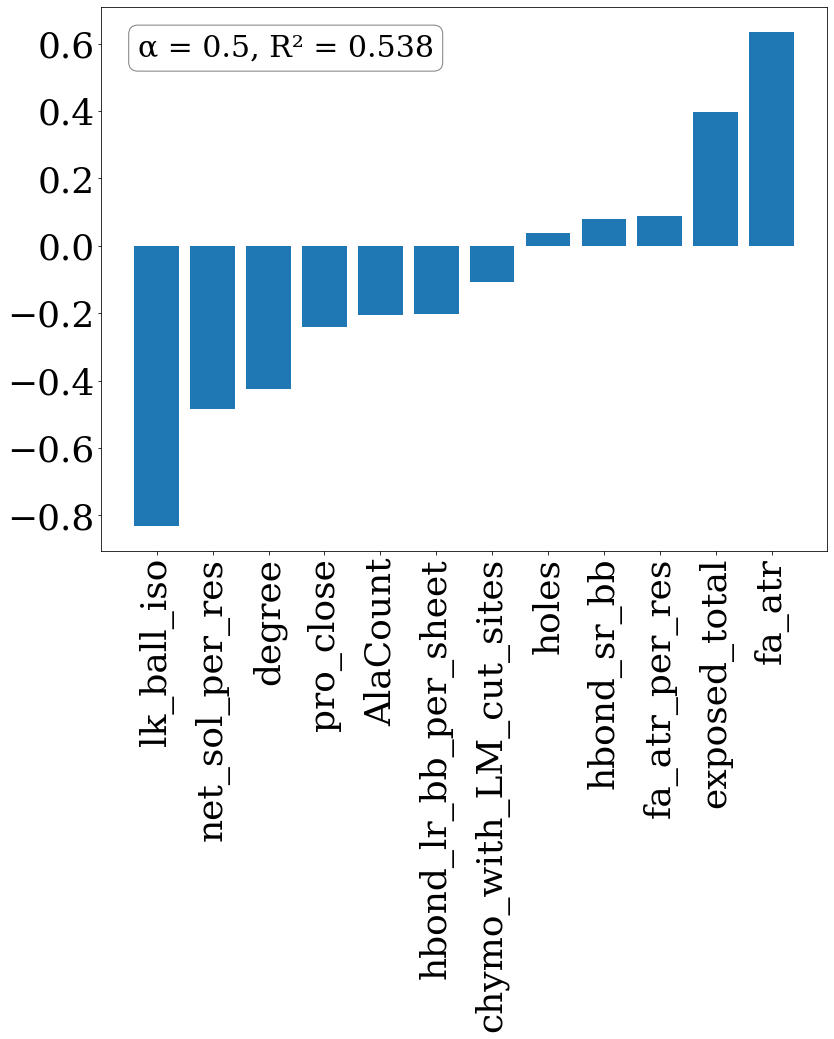


alpha= 0.1


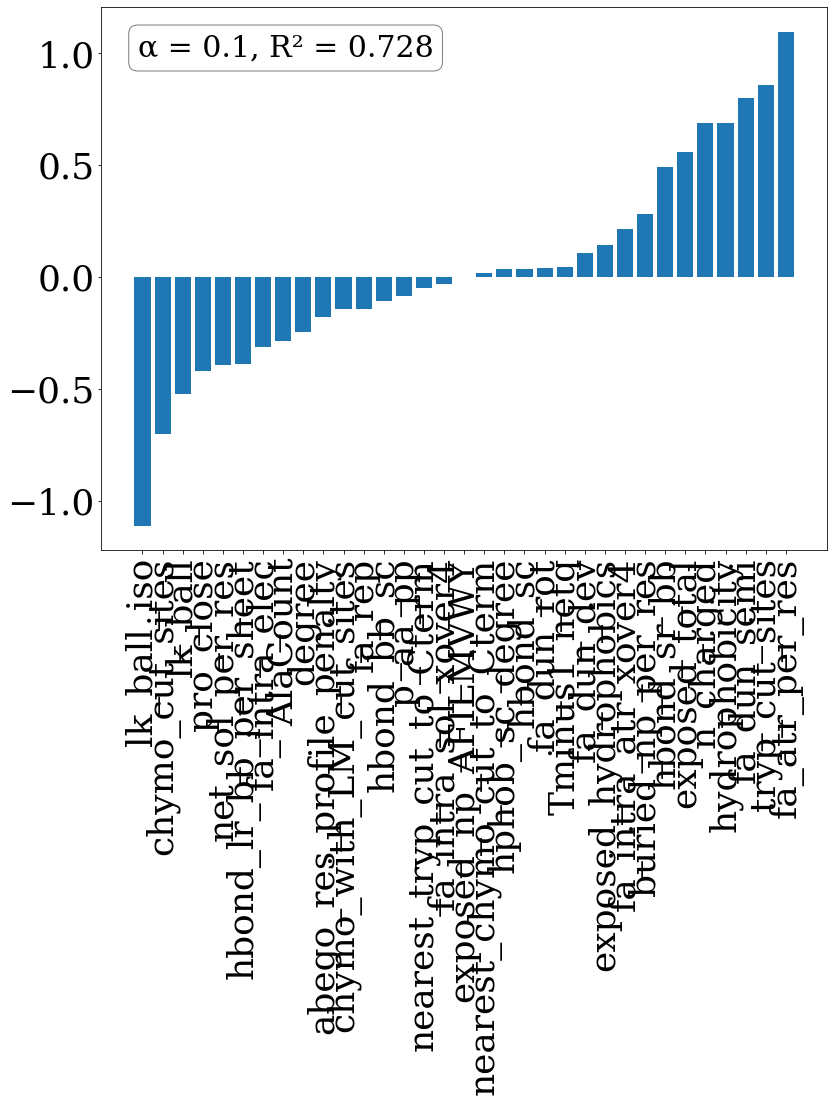

In [130]:
alpha_values = [2,1,.5,.1]
lasso_models = []
for a in alpha_values:
    
    lasso_1 = Lasso(alpha=a)

    lasso_1.fit(X_train_std,y_train)

    lasso_1.score(X_test_std,y_test)

    lasso_coeffs = list(zip(X_train_std.columns,lasso_1.coef_))
    print(f"alpha= {a}")
    plot_zipped_results(lasso_coeffs,lasso_1)
    lasso_models.append(lasso_1)
    print()

## Permutation Analysis

In [131]:
#eli5.formatters.as_dataframe.explain_weights_df(perm)

In [132]:
# imp_vals, imp_all = feature_importance_permutation(
#     predict_method=model_lnr.predict, 
#     X=X_test_std.values,
#     y=y_test,
#     metric='r2',
#     num_rounds=10)

lasso_model = lasso_models[-2]

imp_vals, imp_all = feature_importance_permutation(
    predict_method=lasso_model.predict, 
    X=X_test_std.values,
    y=y_test,
    metric='r2',
    num_rounds=10)

In [133]:
std = np.std(imp_all, axis=1)

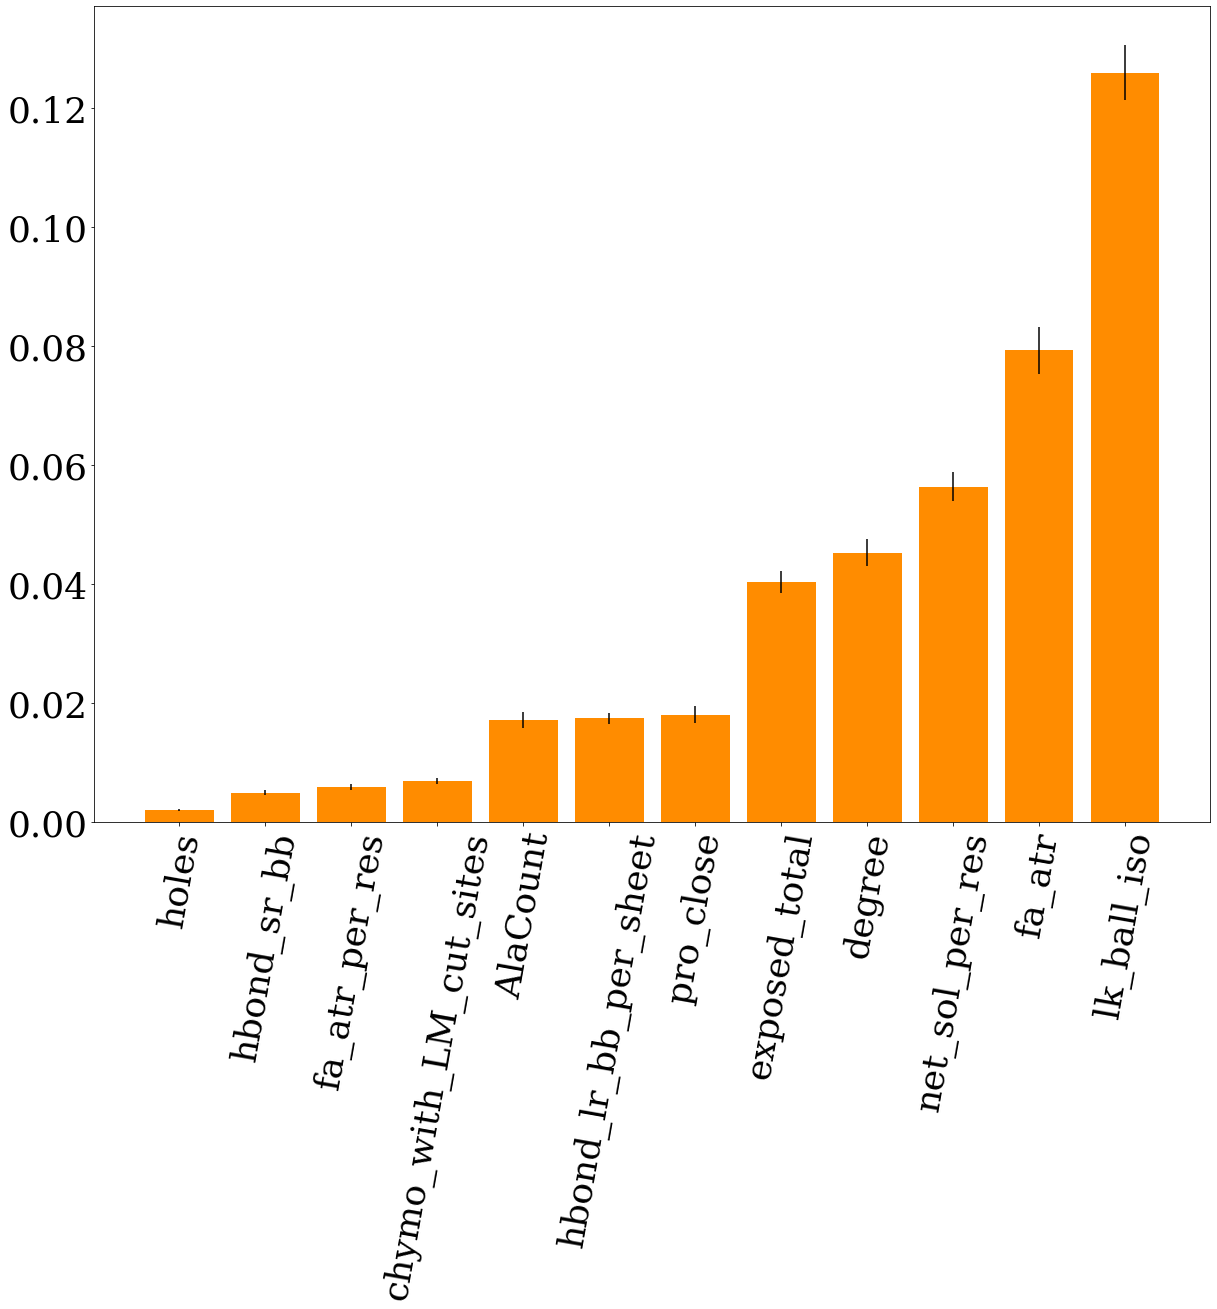

In [135]:
zipped_perm = zip(X_test_std.columns,list(imp_vals),std)
perm_dict = {}
for pair in zipped_perm:
    if abs(pair[1]) > 0:
        perm_dict[pair[0]] = [pair[1],pair[2]]

sorted_dict_tuple = sorted(perm_dict.items(), key=operator.itemgetter(1))
sorted_perm_dict = dict(sorted_dict_tuple)

sorted_coeffs = [sorted_perm_dict[key][0] for key in sorted_perm_dict]
sorted_coeffs_std = [sorted_perm_dict[key][1] for key in sorted_perm_dict]
f, __ = plt.subplots(0,0,figsize=(20,15),subplot_kw={"aspect":1.618})
plt.bar(sorted_perm_dict.keys(), sorted_coeffs,yerr=sorted_coeffs_std,color='darkorange')
plt.xticks(rotation="80",fontsize="36")
plt.yticks(fontsize='36')
model_score = round(lasso_model.score(X_test_std,y_test),3)

textstr = "R² = %0.3f"%(model_score)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=30,
#     verticalalignment='top',bbox=props)


#plt.title(f"Permutation Feature Importance Values. R²={model_score}",fontsize=30)
#plt.savefig(f"./SavedFigures/Permutation_R2_{model_score}.png",dpi=300,bbox_inches='tight')
plt.show()

## manual permutation

In [21]:
original = .8816
new = []
for feature in ros_features:
    new_ros_features = ros_features.copy() #make a copy of rosetta features
    new_ros_features.remove(feature) #drop the feature you are currently iterating on
    
    #set up splits
    X_train = train[new_ros_features]
    y_train = train["S_PC"]

    X_test = test[new_ros_features]
    y_test = test["S_PC"]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    y = pd.concat([y_train,y_test])
    
    
    #set up a linear regression trained to predict S_PC
    model_lnr = LinearRegression(normalize=False)

    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)
    
    
    r2_val = r2_score(y_test.values,y_pred_lnr)

    #get results
#     print("Dropped: ",feature)
#     print("R2 Score: ",r2_val)
#     print()
    
    new.append(r2_val)

In [22]:
delta = [val - original for val in new]

In [37]:
pd.DataFrame(list(zip(ros_features,new,delta)))

,0,1,2
0,AlaCount,0.881565,-0.000035
1,T1_absq,0.881567,-0.000033
2,T1_netq,0.881563,-0.000037
3,Tend_absq,0.881564,-0.000036
4,Tend_netq,0.881565,-0.000035
...,...,...,...
108,total_score,0.881566,-0.000034
109,tryp_cut_sites,0.876582,-0.005018
110,two_core_each,0.881428,-0.000172
111,worst6frags,0.881562,-0.000038


So individually permuting the features gives me a different take on importances because these features have high covariances, therefore I need to account for this .

# Model Audit

In [76]:
import shap
import time
import warnings
warnings.filterwarnings('ignore')

In [77]:
features = ros_features
train_X = X_train
test_X = X_test

train_X_df = pd.DataFrame(data=train_X, columns=features)
test_X_df = pd.DataFrame(data=test_X, columns=features)

In [78]:
X_train_summary = shap.kmeans(train_X, 10)

shap.initjs()      

explainer = shap.KernelExplainer(model_lnr.predict, X_train_summary)

In [79]:
# this was already 
shap_values = explainer.shap_values(test_X_df)

means = []

totals_list = [0.0 for f in features]

100%|██████████| 16052/16052 [1:39:58<00:00,  2.64it/s]


In [80]:
for val_list in shap_values:
    for i in range(0, len(val_list)):
        totals_list[i] += np.fabs(val_list[i])
means = [(feat, total / len(shap_values)) for feat, total in zip(features, totals_list)]
# mean_shaps are returned for use as feature_importances
mean_shaps = sorted(means, key=itemgetter(1), reverse=True)

In [81]:
shap_values_df = pd.DataFrame(shap_values,columns=test_X_df.columns)
shap_values_df.to_csv("shap_values_df.csv",index=False)

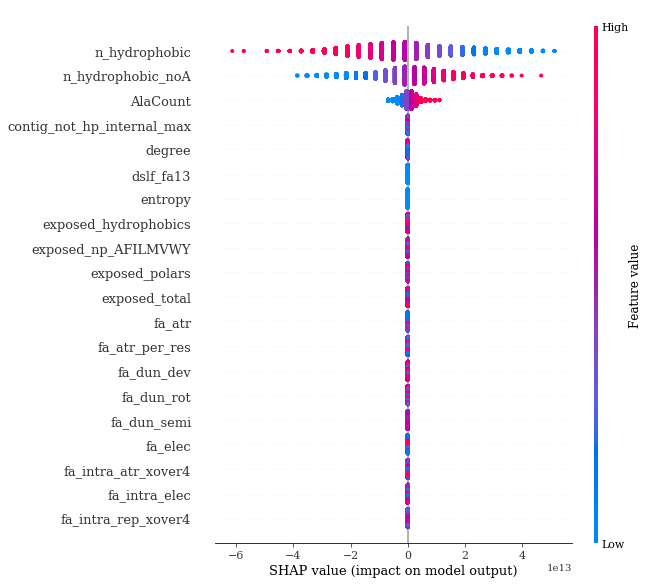

In [82]:
shap.summary_plot(shap_values, test_X_df, show=False, plot_type="dot")

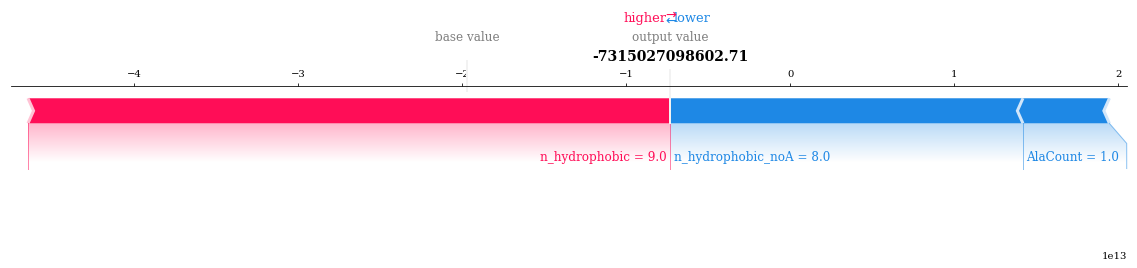

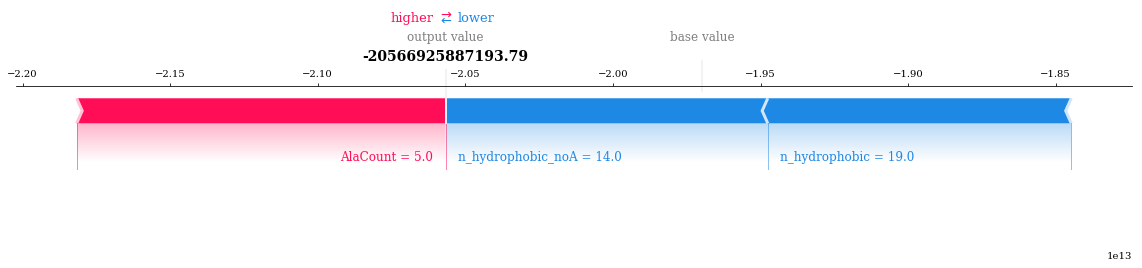

In [83]:
shap.force_plot(explainer.expected_value, shap_values[5694, :], test_X_df.iloc[5694, :], matplotlib=True, show=True)

shap.force_plot(explainer.expected_value, shap_values[10282, :], test_X_df.iloc[10282, :], matplotlib=True, show=True)

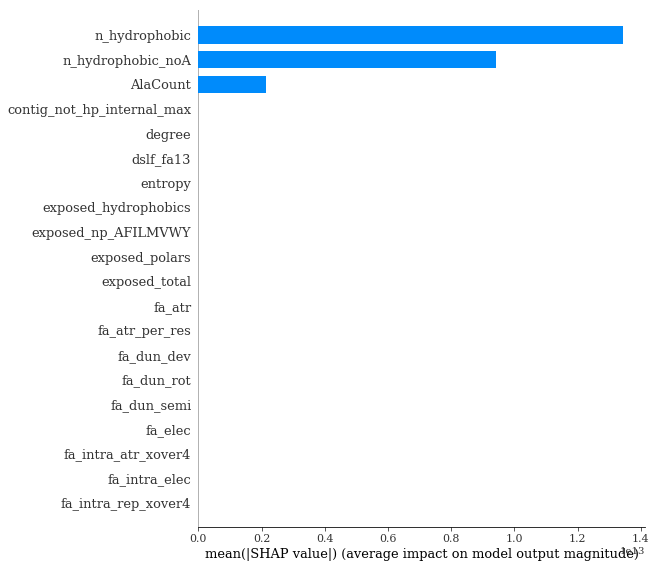

In [84]:
shap.summary_plot(shap_values, test_X_df, plot_type="bar", show=True)

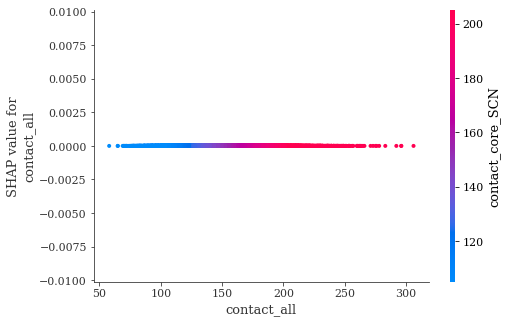

In [85]:
shap.dependence_plot('contact_all',shap_values, test_X_df,interaction_index="contact_core_SCN")

### Downselected features audit (R² = .703 model)

In [86]:
features = ros_features
train_X = X_train_std
test_X = X_test_std

train_X_df = pd.DataFrame(data=train_X, columns=features)
test_X_df = pd.DataFrame(data=test_X, columns=features)

X_train_summary = shap.kmeans(train_X, 10)

shap.initjs()      

explainer = shap.KernelExplainer(lasso_models[-2].predict, X_train_summary)

# this was already 
shap_values = explainer.shap_values(test_X_df)

means = []

totals_list = [0.0 for f in features]

for val_list in shap_values:
    for i in range(0, len(val_list)):
        totals_list[i] += np.fabs(val_list[i])
means = [(feat, total / len(shap_values)) for feat, total in zip(features, totals_list)]
# mean_shaps are returned for use as feature_importances
mean_shaps = sorted(means, key=itemgetter(1), reverse=True)

shap_values_df = pd.DataFrame(shap_values,columns=test_X_df.columns)
shap_values_df.to_csv("shap_values_df.csv",index=False)

100%|██████████| 16052/16052 [1:31:43<00:00,  3.01it/s]


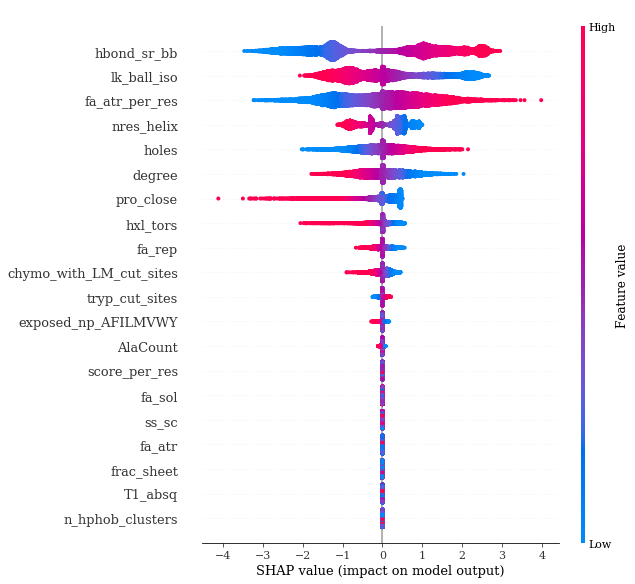

In [107]:
for val_list in shap_values:
    for i in range(0, len(val_list)):
        totals_list[i] += np.fabs(val_list[i])
means = [(feat, total / len(shap_values)) for feat, total in zip(features, totals_list)]
# mean_shaps are returned for use as feature_importances
mean_shaps = sorted(means, key=itemgetter(1), reverse=True)

shap_values_df = pd.DataFrame(shap_values,columns=test_X_df.columns)
shap_values_df.to_csv("shap_values_df.csv",index=False)

shap.summary_plot(shap_values, test_X_df, show=False, plot_type="dot")
plt.savefig("Figure6a",dpi=300,bbox_inches="tight")

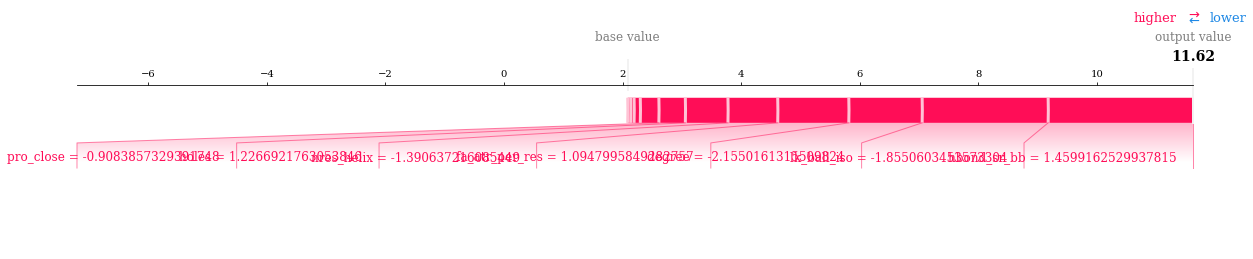

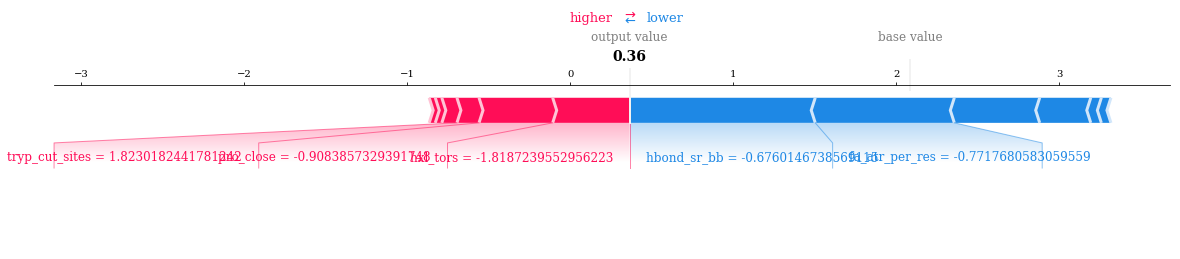

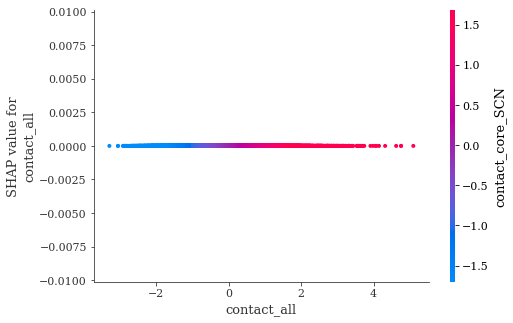

In [108]:
shap.force_plot(explainer.expected_value, shap_values[5694, :], test_X_df.iloc[5694, :], matplotlib=True, show=True)

shap.force_plot(explainer.expected_value, shap_values[10282, :], test_X_df.iloc[10282, :], matplotlib=True, show=True)
plt.close("all")
shap.summary_plot(shap_values, test_X_df, plot_type="bar", show=False)
plt.savefig("Figure6b",dpi=300,bbox_inches="tight")
plt.close('all')
shap.dependence_plot('contact_all',shap_values, test_X_df,interaction_index="contact_core_SCN")